## Problem: 
    we want to solve: How to take larger contexts in a manageable way. 
    We cannot just use tables like we did with bigrams (context of one char to predict next char) because they grow exponentially. 
## Solution:
    We will use approach used in Bengio et al. paper. We will embed chars into a n dimensional vector space (a space smaller than number of chars which is 27). 
    
    In this space related chars will be clustered together within the vector space, allowing us to generalize relationships so we can predict next chars in novel starting points.
    
    At first the embeddings will be random, i.e., the vectors representing chars will be placed randomly within the vector space. Then, using backpropagation in our multilayer neural network, we will change the locations of the vectors within the vector space so that chars that are often combined (in a context of n characters) are placed closely together.
    
    "We can, through the embedding space, transfer knowledge and generalize to novel scenarios."

### What our neural network architecture looks like:

It will essentially consist of 3 main layers:
1. An input layer
    - where the size depends on: 
        1. n - the context length (how many chars we will use to predict next char)
        2. m - the number of dimensions of the vector space we will use to embed chars (i.e., represent unique chars as a vector of m numbers).
    - number of neurons in our input layer is n * m
    - this first layer has linear neurons (i.e., neurons with no non-linearity) and their weight matrix is the LUT C (the embedding matrix). We are essentially encoding ints into one-hot, embedding them into the LUT, and then feeding the embedding LUT C into the next layer of our NN (which is 2. the hidden layer)
2. A "hidden layer" that has a tanh non-linearity. This layer is fully connected to our input layer
    - i.e., fully connected to the numbers representing the n chars used as inputs. So the n*m inputs will be fed into the tanh layer
3. An output layer 
    - all neurons of output layer are fully connected to all neurons of tanh (non-linearity) layer
    - will output a char chosen from the 27 possible number of chars. The chosen char will be the char with the highest probability based off of the previous n chars. And this probability will be tuned over several epochs to minimize a loss value (which measures the quality of our NN).
        - Note: the loss will use negative log likelihood
    - Most computation will be in this output layer. So this layer is the most performance expensive layer of our NN.
    - This layer will have 27 logits, so this layer will have softmax layer on top of it. Everyone of these logits gets exponentiated and they are normalized so all logits sum to 1. This will then give us a useful probability distribution for the next char in the sequence.
        - During training we will have labels (the identity of the correct next char in the sequence). That char (represented as an int index) will be used to pluck out the probability of that char. The NN will be trained, i.e., the parameters of our NN will be tuned, to maximize the probability of that char (given the n previous chars in the sequence). 

Note: These parameters of our NN are the weights and biases of the output layer and our hidden layer, as well as the embedding LUT (C) within our input layer. All these parameters are optimized using backprop.
    

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words) # print number of names

32033

In [4]:
# build the vocab of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # chars from 1-26 are alpha
stoi['.'] = 0 # special char to delineate begin/end of word
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length; num of previous tokens (chars) used to predict next token (char)
X, Y = [],[] # X contains inputs to NN, Y contains the labels for each example inside X

for w in words[:5]: # loop through training set (or subset of training set)
    
    print(w) # print entire word (name)
    context = [0] * block_size # padded tokens, remember that 0 maps to '.' (special char)
    for ch in w + '.':
        ix = stoi[ch] # enumerate chars; convert ch to int val
        X.append(context) # build out array X which stores running context
        Y.append(ix) # build out array Y for current character
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append (rolling window of context), decrement padding as chars are appended
        # remember location 1 above refers to second char in string

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype
# from the 5 words (inputs) we have created a data set of 32 examples
# and each input to the NN is 3 integers 
# label Y is also an integer 

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X # X is a n x m matrix
# n = number of input chars (examples) and m is context length (num of chars used to predict next char)

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

# Task: Build NN that takes Xs and predicts Ys

## How embedding chars into the Look Up Table works

We will use a char (an int between 0-26) to index into a $27*m$ matrix that represents a LUT, where m is the number of dimensions of a vector space we want to embed chars into.

Every index (representing a char) is plucking out a row of the embedding matrix, so that each index is converted into the m-dimensional vector that corresponds to the embedding vector for that char.

So basically embedding means we will represent an int (which itself represents a char) as a vector of m numbers (assuming float values). So if we have a context length of 3 chars and m = 30. Our input layer will have 90 numbers that represent 3 chars.

The same LUT matrix will be shared by all chars

### Build lookup table

In [8]:
# just like Bengio et al. paper, we will embed 27 possible chars
# in smaller dimensional space

# each of the 27 chars will have a 2-dimensional embedding
C = torch.randn([27,2]) 

#### We will embedd all ints inside input X into LUT C 

There are two ways to embed a single int (e.g., 5) into LUT C

#### 1) take C and index into row 5

In [9]:
C[5]

tensor([-1.5142, -0.9512])

##### Method 2: use one-hot encoding 
- Even though it may not immediately seem like it, this method is actually identical to first method

In [10]:
# create a 27-D vector (i.e., array of 27 nums) with all 0s except for the 5th element in vector which is 1
# i.e., 5th dimension is 1
# we then cast to float() so we can multiply by matrix C

# the one-hot encoding will essentially pluck out 5th row of C
# because 0s mask the other rows
# giving us the same result as the first method for embeding an int above
F.one_hot(torch.tensor(5), num_classes=27).float() @ C


tensor([-1.5142, -0.9512])

#### For efficiency we will use first method for embedding (just indexing into row of LUT C)

Even easier, We can embed using tensors to simultaneously embed all 32x3 input ints (in array X) into the LUT

In [11]:
# C[X] # prints the embedding of inputs tensor X
# C[X].shape # [32,3,2] # 32 input nums, context length 3, embedded into 2 dimensions

In [12]:
X[13,2]

tensor(1)

In [13]:
C[X][13,2]

tensor([1.2006, 0.0091])

In [14]:
C[1]

tensor([1.2006, 0.0091])

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## Construct hidden layer

In [16]:
# weights, the num of inputs to this layer will be 3x2 = 6 (3 2D embeddings)
# num of neurons in this layer is a var up to us, we will use 100
W1  = torch.randn((6,100))

# biases
b1 = torch.randn(100)

### what we want to do:
 ##### take input (i.e., embedding) and multiply it by weights and add bias
emb @ W1 + b1

### Problem, why we cant do this: The embeddings are stacked up in the dimensions of the tensor C

### Solution: Concatenate inputs and transform [32,3,2] tensor into a [32,6] tensor

There are many ways to do this in Torch, one way to concatenate the tensors in our input layer is using `torch.cat` (concatenates sequence of tensors in the given dimension)

In [17]:
# bad way to remove dimensions stacked up in tensor C and concatenate them.
# bad because this is not generalizable/scalable, e.g., if we change the block size (i.e., context-length)

torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape # concatenates tensors along dimension 1 (second dimension)
# essentially plucks out the 32 3x2 matrices and concatenates them so that we have 32 vectors with 6 elements

torch.Size([32, 6])

In [18]:
# better way to remove a Tensor dimension (pluck out the 32 3x2 matrices)
tlist = torch.unbind(emb,1)
# above is equivalent to list [emb[:,0,:],emb[:,1,:],emb[:,2,:]]
torch.cat(tlist,1)

tensor([[ 0.5535, -0.7468,  0.5535, -0.7468,  0.5535, -0.7468],
        [ 0.5535, -0.7468,  0.5535, -0.7468, -1.5142, -0.9512],
        [ 0.5535, -0.7468, -1.5142, -0.9512,  0.0913,  0.7544],
        [-1.5142, -0.9512,  0.0913,  0.7544,  0.0913,  0.7544],
        [ 0.0913,  0.7544,  0.0913,  0.7544,  1.2006,  0.0091],
        [ 0.5535, -0.7468,  0.5535, -0.7468,  0.5535, -0.7468],
        [ 0.5535, -0.7468,  0.5535, -0.7468, -1.0731,  0.4976],
        [ 0.5535, -0.7468, -1.0731,  0.4976,  1.0326, -0.4490],
        [-1.0731,  0.4976,  1.0326, -0.4490, -0.0511,  1.8401],
        [ 1.0326, -0.4490, -0.0511,  1.8401, -0.2095, -1.1081],
        [-0.0511,  1.8401, -0.2095, -1.1081, -0.0511,  1.8401],
        [-0.2095, -1.1081, -0.0511,  1.8401,  1.2006,  0.0091],
        [ 0.5535, -0.7468,  0.5535, -0.7468,  0.5535, -0.7468],
        [ 0.5535, -0.7468,  0.5535, -0.7468,  1.2006,  0.0091],
        [ 0.5535, -0.7468,  1.2006,  0.0091, -0.2095, -1.1081],
        [ 1.2006,  0.0091, -0.2095, -1.1

## An even better way to pop out dimensions from tensors and concatenate them 
*which we need to multiply the input embedding matrix by weights and add bias for our hidden layer

### Notes on how tensors are implemented in PyTorch

n-dimensional tensors are simply represented as a 1-Dimensional array/vector of values (e.g., ints)

`.view()` allows us to interpret any 1-D array of values as an n-dimensional tensor. This works as long as the sum of the number of dimensions is equal to the sum of the number elements
- When using `.view` no memory is being changed, copied, moved or created–<mark>so this operation is extremely efficient</mark>. The storage is identical to the 1-D representation. Storage offset, strides and shapes are manipulated so that the 1-D sequence of bytes is seen as a n-dimensional arrays

See: [PyTorch Internals](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [19]:
# below effectively does the same as before (pops out dimensions and stacks them up in a single row)
emb.view(32,6) == torch.cat(torch.unbind(emb,1),1) # verifies via element-wise equals operation that two methods output same result

# CONCATENATION IS MUCH LESS EFFICIENT BECAUSE IT CREATES A WHOLE NEW TENSOR WITH NEW STORAGE
# - 

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

#### # CONCATENATION IS MUCH LESS EFFICIENT
- It creates a new tensor (new memory is being created), because there's no way to concanetate tensors just by manupulating view attributes

In [20]:
# And now it works!
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
# hidden layer creates 100 activations for every one of our (32 or whatever the value of first dimension is) activations
# also adds tanh nonlinearity
h

tensor([[-0.9983, -0.6663,  0.4032,  ..., -0.9942,  0.9947, -0.9960],
        [-0.3529, -0.7730, -0.9862,  ..., -0.9956,  0.6850, -0.9966],
        [-0.3379,  1.0000, -0.9994,  ..., -1.0000,  0.9885, -0.3461],
        ...,
        [-0.9920, -0.9992,  1.0000,  ...,  0.9999,  0.3610,  0.7997],
        [ 0.9999,  0.4524, -0.9072,  ..., -0.9999, -0.9945,  0.9975],
        [-0.9999,  0.7241,  0.9993,  ..., -0.6600,  1.0000,  0.9979]])

In [21]:
# we can also us [-1] dimension for PyTorch to infer the correct dimension to use
# h = torch.tanh(emb.view(-1,6) @ W1 + b1)

### How the 1-D array of biases are added to the tensor in hidden layer
*Review of how broadcasting works

Basically if (after our embedding matrix gets multiplied by the weight matrix) its a [32,100] matrix, then the vector [100] gets broadcasted as a [1,100] tensor. So it will get copied for each of the 32 rows and do an element wise addition. I.e., the same bias vector will be added to all the rows of the embedding matrix.

So the addition will look like:
 [32,100]
+[1,100]



## Next: Create output layer

In [22]:
#  create W2 and B2 for output layer
W2  = torch.randn((100,27)) # take 100 neurons from hidden layer as input, and output 27, # of possible chars

# biases
b2 = torch.randn(27) # 27 because output is 27

In [23]:
logits = h @ W2 + b2

In [24]:
logits.shape

torch.Size([32, 27])

In [25]:
counts = logits.exp()

In [26]:
prob = counts / counts.sum(1,keepdims=True)

In [27]:
prob[0].sum()

tensor(1.0000)

In [28]:
# this gives current probabilities to labels (correct char in sequence) given current weights of NN
#prob[torch.arange(32),Y]

# calculate negative log likelihood loss value
loss = -prob[torch.arange(32),Y].log().mean()
loss # we want to minimize this loss to get NN to predict correct next  chars in sequence

tensor(17.1650)

## Cleaner version of NN

In [29]:
# params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)

W1 = torch.randn((6,100), generator=g) # 6 inputs 100 outputs
b1 = torch.randn(100, generator=g) # will be broadcasted when added to W1

W2 = torch.randn((100,27), generator=g) # 100 outputs from hidden layer, 27 outputs (27 chars possible)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

In [30]:
sum(p.nelement() for p in parameters) # num of total params

3481

In [31]:
emb = C[X] # build LUT embedding matrix, (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100) hidden layer
logits = h @ W2 + b2 # (32,27)
counts = logits.exp()
prob = counts/counts.sum(1,keepdims=True)
loss = -prob[torch.arange(32),Y].log().mean()
loss # measures how well NN predicts correct output (next char in sequence) given its current parameters

tensor(17.7697)

### easier, more efficient way to calculate loss using logits and Y (output labels)
`cross_entropy()` is more efficient because:
1) it avoids copying and creating new tensors in memory which above method requires. Instead PyTorch, when calling cross_entropy, will cluster up these operations above and use "fused kernels" that efficiently evaluate these expressions (clustered mathematical operations)
2) The backward pass can be made much more efficient, due to the clustered mathematical expression its simpler and easier to implement the backward pass
3) Under the hood, `cross_entropy` is more numerically well-behaved
- PyTorch solves floating point bad behavior from when logits have extreme values (e.g., 2^100 will be out of range for float values so it will ruin the probability distribution)

In [32]:
# before beginning training loop make sure that for all parameters
# p.requires_grad is set to True
for p in parameters:
    p.requires_grad = True

In [33]:
# TRAINING LOOP
for _ in range(10):
    # forward pass
    emb = C[X] # build LUT embedding matrix, (num of examples,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100) hidden layer
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y) # replaces counts, prob and loss lines above
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None # initialize grad vals to 0
    loss.backward() # populates gradients

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad 
        
#print(loss.item())

17.76971435546875
13.656402587890625
11.298770904541016
9.452458381652832
7.984263896942139
6.891323089599609
6.100015640258789
5.452036380767822
4.8981523513793945
4.414664268493652


### ABOVE: we are "overfitting to one batch of data". 
I.e., we are only tuning the weights of our NN to predict the next char given prev chars for 32 char examples from our data set.

### ALSO: We cannot achieve a loss of 0 because:
There are cases where a unique input doesn't have a unique output. E.g., if there are no previous chars, there's an equal likelihood of it being any of the starting chars in our data set.

In [34]:
# UPDATING TO TRAIN ENTIRE DATASET

# build the dataset

block_size = 3 # context length; num of previous tokens (chars) used to predict next token (char)
X, Y = [],[] # X contains inputs to NN, Y contains the labels for each example inside X

for w in words: # loop through training set (or subset of training set)
    
    #print(w) # print entire word (name)
    context = [0] * block_size # padded tokens, remember that 0 maps to '.' (special char)
    for ch in w + '.':
        ix = stoi[ch] # enumerate chars; convert ch to int val
        X.append(context) # build out array X which stores running context
        Y.append(ix) # build out array Y for current character
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append (rolling window of context), decrement padding as chars are appended
        # remember location 1 above refers to second char in string

X = torch.tensor(X)
Y = torch.tensor(Y)

In [35]:
X.shape, Y.shape # now we have 228146 inputs and outputs

(torch.Size([228146, 3]), torch.Size([228146]))

### Addressing how long it takes to train on whole dataset.

### SOLUTION: Train on (random) minibatches

In [36]:
torch.randint(0,X.shape[0],(32,))

tensor([ 25360, 213361,  12738, 199224,  18008, 200474,  58929, 197190, 156687,
         55098, 200413, 125946,  95544, 124879,  30012, 172255, 141405, 104196,
         76556, 138928,  93341,  18523, 129753,  16354,  33144, 227834, 174590,
        204376,  38079,  91420, 170942,  94340])

In [37]:
# set for updated NN

# params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)

W1 = torch.randn((6,100), generator=g) # 6 inputs 100 outputs
b1 = torch.randn(100, generator=g) # will be broadcasted when added to W1

W2 = torch.randn((100,27), generator=g) # 100 outputs from hidden layer, 27 outputs (27 chars possible)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

In [38]:
# TEST LEARNING RATE between values -1 and -0.001

lre = torch.linspace(-3,0,1000) # we will get a 1000 values between -3 and 0 (which we will use as exponents)
lrs = 10**lre

In [39]:
# TRAINING LOOP using minibatches
# not as good quality as training on entire data set but it's way faster

# collect learning rates as a list for diff values
lri = []
lossi = []

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0,X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # UPDATED build LUT embedding matrix, (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100) hidden layer
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix]) # replaces counts, prob and loss lines above
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None # initialize grad vals to 0
    loss.backward() # populates gradients

    # update parameters
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad 
        
    # track stats for learning rates
    #lri.append(lre[i])
    #lossi.append(loss.item())
        
#print(loss.item()) # calculates loss on minibatch

In [40]:
# plot learning rates and losses
#plt.plot(lri,lossi) # we see somewhere around 10^-1 i.e., -0.1 is a an ideal setting for learning rate

In [41]:
# calculate loss for entire data set after training
emb = C[X] 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4961, grad_fn=<NllLossBackward0>)

### It's better to have an approx gradient and make more steps, than to eval the exact gradient and take fewer steps. This is why minibatches work well in practice.

## How to find a good initial learning rate:

Too big: 
- E.g.,  `p.data += -10 * p.grad` will lead to erratic behavior and cause the NN to not learn effectively. It'll jump up and down sharply in loss values.
    
Too small:
- E.g., e.g., `p.data += -0.00001 * p.grad` will learn way too slowly (if at all)


See TEST LEARNING RATE above

## Near the end of training it is standard to use a learning rate decay

This involves lowering the magnitude of the learning rate so that smaller steps are taken near the end. Guessing this is for more precision?

## Avoiding overfitting to dataset (where NN just remembers dataset verbatim, having 0 loss on training set and high loss on novel data)

### Splitting up dataset into 3 splits:
1. Training split
- Typically 80% of dataset
- Used to optimize params of model using grad descent (like we did above)
2. Dev/Validation split
- Typically 10% of dataset
- Used to train/test hyperparams (size of hidden layer, size of embedding matrix LUT, strength of regularization, etc.)
3. Test split
- Typically 10% of dataset
- Test on test spli dataset sparingly to avoid training on it and overfitting to it

In [42]:
# build the dataset (split into 3)

def build_dataset(words):
    block_size = 3 # context length, how many chars we take to predict the next one
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padded tokens
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    #print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words) # randomly shuffle words (so unsorted)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # build training dataset (words 80% of dataset)
Xdev, Ydev = build_dataset(words[n1:n2]) # build dev dataset (words 80-90, so 10%)
Xte, Yte = build_dataset(words[n2:]) # build test dataset (words 90-100, so last 10% of dataset)

In [43]:
# set for updated NN

# params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)

W1 = torch.randn((6,100), generator=g) # 6 inputs 100 outputs
b1 = torch.randn(100, generator=g) # will be broadcasted when added to W1

W2 = torch.randn((100,27), generator=g) # 100 outputs from hidden layer, 27 outputs (27 chars possible)
b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

In [44]:
# TRAINING LOOP using minibatches
# not as good quality as training on entire data set but it's way faster

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # UPDATED build LUT embedding matrix, (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100) hidden layer
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix]) # replaces counts, prob and loss lines above
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None # initialize grad vals to 0
    loss.backward() # populates gradients

    # update parameters
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
#print(loss.item()) # calculates loss on minibatch

In [45]:
print(loss.item()) # calculates loss on minibatch

2.5223772525787354


In [46]:
# calculate loss for training dataset
emb = C[Xtr] # changed to using Xdev for evaluation
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5744, grad_fn=<NllLossBackward0>)

In [47]:
# calculate loss for dev dataset
emb = C[Xdev] # changed to using Xdev for evaluation
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5687, grad_fn=<NllLossBackward0>)

### We are "underfitting" because the training loss and dev loss are roughly equal. This means we can make performance improvements by scaling up the size of NN

## Next steps: Experimenting with larger hidden layer

We should expect a lower loss because we have a bigger model (which should "underfit" less)

In [48]:
# set for updated NN, LARGER HIDDEN LAYER

# params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)

# UPDATED
W1 = torch.randn((6,300), generator=g) # 6 inputs 300 outputs <------
b1 = torch.randn(300, generator=g) # will be broadcasted when added to W1
W2 = torch.randn((300,27), generator=g) # 100 outputs from hidden layer, 27 outputs (27 chars possible)

b2 = torch.randn(27, generator=g)
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

In [49]:
#sum(p.nelement() for p in parameters) # num of parameters has updated since we increased size of hidden layer

In [50]:
# TRAINING LOOP using minibatches
# not as good quality as training on entire data set but it's way faster

# collect learning rates as a list for diff values
lri = []
lossi = []
stepsi = [] # UDPATED, used to plot loss against step size

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0,X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # UPDATED build LUT embedding matrix, (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100) hidden layer
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix]) # replaces counts, prob and loss lines above
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None # initialize grad vals to 0
    loss.backward() # populates gradients

    # update parameters
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # track stats for learning rates
    #lri.append(lre[i])
    stepsi.append(i)
    lossi.append(loss.item())
        
#print(loss.item()) # calculates loss on minibatch

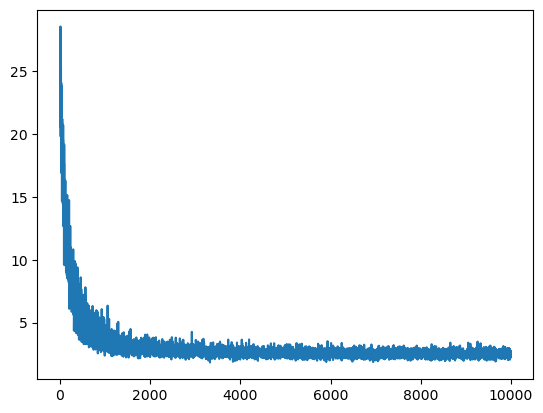

In [51]:
plt.plot(stepsi,lossi) # the thickness in plot is due to noise (from small batch size)

In [52]:
# calculate loss for training dataset
emb = C[Xtr] # changed to using Xdev for evaluation
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5249, grad_fn=<NllLossBackward0>)

In [53]:
# calculate loss for dev dataset
emb = C[Xdev] # changed to using Xdev for evaluation
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5135, grad_fn=<NllLossBackward0>)

### Potential bottleneck of network (preventing from getting lower loss): Embedding matrix has too few dimensions. So the problem could be that we are cramming too many characters in a 2D vector, so NN can't use that space effectively

So we will try to change the character embedding size

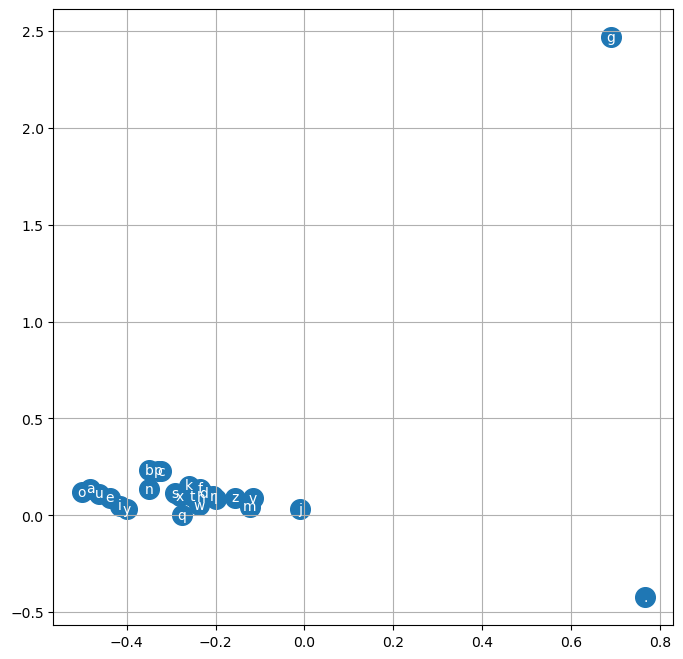

In [56]:
# plot to visualize embedding matrix
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')